In [8]:
# Libraries
import torch
import matplotlib.pyplot as plt
from sde_sampler.additions.hacking import TrainableWrapper

In [9]:
# Pytorch device
device = torch.device('cuda')

Build the model targeting the `two_modes` target with the `vp_rds` solver and the `ei_reference_sde_lv` loss. Note that we use the `basic` control parametrization with doesn't depend on the score of the target distribution.

In [10]:
# Load the right configuration
from hydra import initialize, compose
from hydra.utils import instantiate
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(overrides=["+target=two_modes", "+solver=vp_rds", "loss=ei_reference_sde_lv", "model@generative_ctrl=basic"])
    cfg['train_steps'] = 256
    cfg['train_batch_size'] = 1024
    cfg['eval_batch_size'] = 8192
model = instantiate(cfg.solver, cfg)
model.setup()

Define the score of the target distribution

In [11]:
# Build the target's score
def target_log_prob_and_grad(y):
    y_ = torch.autograd.Variable(y.clone(), requires_grad=True)
    log_prob_y = model.target.log_prob(y_)
    return log_prob_y.flatten(), torch.autograd.grad(log_prob_y.sum(), y_)[0].detach()

Sample the target distribution with MCMC initialized at the mode locations

In [12]:
# Sample the target distribution with MCMC
from tqdm import trange
from sde_sampler.additions.mcmc import mala_step, heuristics_step_size
n_chains = 64
step_size = 1e-3 * torch.ones((n_chains, 1), device=device)
y_init = torch.concat([
    model.target.loc[0].unsqueeze(0).expand((n_chains // 2, -1)),
    model.target.loc[1].unsqueeze(0).expand((n_chains // 2, -1))
], dim=0)
y = torch.autograd.Variable(y_init.clone(), requires_grad=True)
target_log_prob_y, target_grad_y = target_log_prob_and_grad(y)
ys = [y.clone().detach().cpu()]
for _ in trange(2048):
    # Run MALA step
    y, target_log_prob_y, target_grad_y, log_acc = mala_step(
        y=y,
        target_log_prob_y=target_log_prob_y,
        target_grad_y=target_grad_y,
        target_log_prob_and_grad=target_log_prob_and_grad,
        step_size=step_size
    )
    # Adapt the step size
    step_size = heuristics_step_size(step_size, log_acc)
    # Save the step
    ys.append(y.detach().clone().cpu())
ys = torch.stack(ys)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:04<00:00, 503.67it/s]


Fit a Gaussian Mixture Model

In [13]:
# Fit a GMM model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(
    n_components=model.target.loc.shape[0],
    covariance_type='diag',
    means_init=model.target.loc.cpu().numpy()
)
gmm = gmm.fit(ys.view((-1, ys.shape[-1])).numpy())

Set the reference of the RDS model

In [14]:
# Change the reference process
model.change_reference_type(
    ref_type='gmm',
    weights=torch.from_numpy(gmm.weights_).to(device),
    means=torch.from_numpy(gmm.means_).to(device),
    variances=torch.from_numpy(gmm.covariances_).to(device)
)

In [15]:
# Run an collect results
model_wrapped = TrainableWrapper(model)
results = model_wrapped.run()

loss=2.25e-02: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:57<00:00,  4.45it/s]


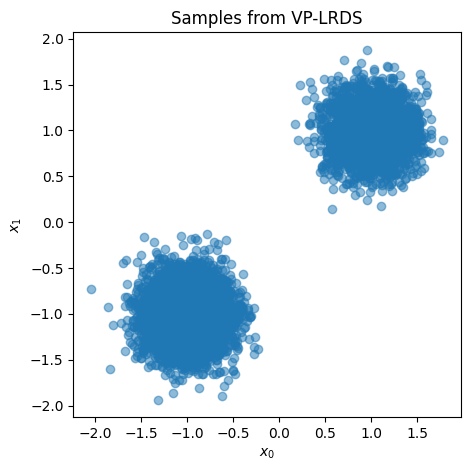

In [16]:
# Display the samples
plt.figure(figsize=(5,5))
plt.scatter(results.samples[:,0].cpu(), results.samples[:,1].cpu(), alpha=0.5)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Samples from VP-LRDS')
plt.show()

Check the metrics of the obtained samples

In [19]:
results.metrics['eval/mode_weight']

63.70849609375